In [1]:
# Import Libraries

import pandas as pd
import numpy as np
import sys, os, csv
from scipy.stats import hypergeom, stats, binomtest
import seaborn as sns
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, LabelSet, CategoricalColorMapper, Span, FactorRange
from bokeh.transform import dodge, factor_cmap
from bokeh.palettes import Spectral11, Category20
from bokeh.layouts import gridplot
import pyranges as pr
import bioframe as bf
import plotly.express as px, plotly.graph_objects as go
from itertools import combinations
from scipy.stats import spearmanr


1. Data obtained from wget https://storage.googleapis.com/gcp-public-data--gnomad/release/2.1.1/constraint/gnomad.v2.1.1.lof_metrics.by_gene.txt.bgz
<br>
2. Data obtained from wget https://storage.googleapis.com/gcp-public-data--gnomad/papers/2019-flagship-lof/v1.0/gnomad.v2.1.1.all_lofs.txt.bgz

https://gnomad.broadinstitute.org/downloads#v2-constraint


Supplementary Dataset 11 | Constraint metrics. Note that this file contains all transcripts: for
gene-based analyses, the file should be filtered to canonical transcripts (`canonical == true`),
and LOEUF decile bin (`oe_lof_upper_bin`) recomputed for each gene. The most commonly
used metrics in this manuscript are `oe_lof_upper`, `oe_lof_upper_bin`, and `p`. 


Columns are:
<br> ● gene: Gene name
<br> ● transcript: Ensembl transcript ID (Gencode v19)
<br> ● canonical: Boolean indicator as to whether the transcript is the canonical transcript for
the gene
<br> ● obs_mis: Number of observed missense variants in transcript
<br> ● exp_mis: Number of expected missense variants in transcript
<br> ● oe_mis: Observed over expected ratio for missense variants in transcript (obs_mis
divided by exp_mis)
<br> ● mu_mis: Mutation rate summed across all possible missense variants in transcript
<br> ● possible_mis: Number of possible missense variants in transcript
<br> ● obs_mis_pphen: Number of observed missense variants in transcript predicted "probably
damaging" by PolyPhen-2
<br> ● exp_mis_pphen: Number of expected missense variants in transcript predicted "probably
damaging" by PolyPhen-2
<br> ● oe_mis_pphen: Observed over expected ratio for PolyPhen-2 predicted "probably
damaging" missense variants in transcript (obs_mis_pphen divided by exp_mis_pphen)
<br> ● possible_mis_pphen: Number of possible missense variants in transcript that are
predicted "probably damaging" by PolyPhen-2
<br> ● obs_syn: Number of observed synonymous variants in transcript
<br> ● exp_syn: Number of expected synonymous variants in transcript
<br> ● oe_syn: Observed over expected ratio for missense variants in transcript (obs_syn
divided by exp_syn)
<br> ● mu_syn: Mutation rate summed across all synonymous variants in transcript
<br> ● possible_syn: Number of possible synonymous variants in transcript
<br> ● obs_lof: Number of observed predicted loss-of-function (pLoF) variants in transcript
<br> ● mu_lof: Mutation rate summed across all possible pLoF variants in transcript
<br> ● possible_lof: Number of possible pLoF variants in transcript
<br> ● exp_lof: Number of expected pLoF variants in transcript
<br> ● pLI: Probability of loss of function intolerance; probability that transcript falls into
distribution of haploinsufficient genes ( about 9% o/e pLoF ratio; computed from gnomAD
data)
<br> ● pRec: Probability that transcript falls into distribution of recessive genes ( about 46% o/e pLoF
ratio; computed from gnomAD data)
<br> ● pNull: Probability that transcript falls into distribution of unconstrained genes (~100% o/e
pLoF ratio; computed from gnomAD data)
<br> ● oe_lof: Observed over expected ratio for pLoF variants in transcript (obs_lof divided by
exp_lof)
<br> ● oe_syn_lower: Lower bound of 90% confidence interval for o/e ratio for synonymous
variants
<br> ● oe_syn_upper: Upper bound of 90% confidence interval for o/e ratio for synonymous
variants
<br> ● oe_mis_lower: Lower bound of 90% confidence interval for o/e ratio for missense
variants
<br> ● oe_mis_upper: Upper bound of 90% confidence interval for o/e ratio for missense
variants
<br> ● oe_lof_lower: Lower bound of 90% confidence interval for o/e ratio for pLoF variants
<br> ● oe_lof_upper: LOEUF: upper bound of 90% confidence interval for o/e ratio for pLoF
variants (lower values indicate more constrained)
<br> ● constraint_flag: Reason gene does not have constraint metrics. One of:
<br> ○ no variants: Zero observed synonymous, missense, pLoF variants
<br> ○ no_exp_syn: Zero expected synonymous variants
<br> ○ no_exp_mis: Zero expected missense variants
<br> ○ no_exp_lof: Zero expected pLoF variants
<br> ○ syn_outlier: Too many or too few synonymous variants; synonymous z score < -5
or synonymous z score > 5
<br> ○ mis_too_many: Too many missense variants; missense z score < -5
<br> ○ lof_too_many: Too many pLoF variants; pLoF z score < -5
<br> ● syn_z: Z score for synonymous variants in gene. Higher (more positive) Z scores
indicate that the transcript is more intolerant of variation (more constrained). Extreme
values of syn_z indicate likely data quality issues
<br> ● mis_z: Z score for missense variants in gene. Higher (more positive) Z scores indicate
that the transcript is more intolerant of variation (more constrained)
<br> ● lof_z: Z score for pLoF variants in gene. Higher (more positive) Z scores indicate that the
transcript is more intolerant of variation (more constrained)
<br> ● oe_lof_upper_rank: Transcript’s rank of LOEUF value compared to all transcripts (lower
values indicate more constrained)
<br> ● oe_lof_upper_bin: Decile bin of LOEUF for given transcript (lower values indicate more
constrained)
<br> ● oe_lof_upper_bin_6: Sextile bin of LOEUF for given transcript (lower values indicate
more constrained)
<br> ● n_sites: Number of distinct pLoF variant sites in the transcript
<br> ● classic_caf: Sum of allele frequencies of pLoFs in the transcript
<br> ● max_af: Maximum allele frequency of any pLoF in the transcript
<br> ● no_lofs: The number of individuals with no observed pLoF variants in the transcript
<br> ● obs_het_lof: The number of individuals with at least one observed heterozygous pLoF
variant, but no homozygous pLoF variants, in the transcript
<br> ● obs_hom_lof: The number of individuals with at least one observed homozygous pLoF in
the transcript
<br> ● defined: The number of individuals where at least one high-quality genotype (including
homozygous reference) is observed at a called site annotated as a pLoF variant
<br> ● p: The estimated proportion of haplotypes with a pLoF variant. Defined as: 1 -
sqrt(no_lofs / defined)
<br> ● exp_hom_lof: The expected number of individuals with at least one homozygous pLoF
variant based on the frequency of pLoF haplotypes. Defined as: defined * p2
<br> ● classic_caf_afr: Sum of allele frequencies of pLoFs in the transcript among
African/African-American individuals
<br> ● classic_caf_amr: Sum of allele frequencies of pLoFs in the transcript among Latino
individuals
<br> ● classic_caf_asj: Sum of allele frequencies of pLoFs in the transcript among Ashkenazi
Jewish individuals
<br> ● classic_caf_eas: Sum of allele frequencies of pLoFs in the transcript among East Asian
individuals
<br> ● classic_caf_fin: Sum of allele frequencies of pLoFs in the transcript among Finnish
individuals
<br> ● classic_caf_nfe: Sum of allele frequencies of pLoFs in the transcript among Non-Finnish
European individuals
<br> ● classic_caf_oth: Sum of allele frequencies of pLoFs in the transcript among Other
(uncharacterized ancestry) individuals
<br> ● classic_caf_sas: Sum of allele frequencies of pLoFs in the transcript among South Asian
individuals
<br> ● p_afr: The computation of `p` repeated among only African/African-American individuals
<br> ● p_amr: The computation of `p` repeated among only Latino individuals
<br> ● p_asj: The computation of `p` repeated among only Ashkenazi Jewish individuals
<br> ● p_eas: The computation of `p` repeated among only East Asian individuals
<br> ● p_fin: The computation of `p` repeated among only Finnish individuals
<br> ● p_nfe: The computation of `p` repeated among only Non-Finnish European individuals
<br> ● p_oth: The computation of `p` repeated among only Other (uncharacterized ancestry)
individuals
<br> ● p_sas: The computation of `p` repeated among only South Asian individuals
<br> ● transcript_type: Transcript biotype (https://www.gencodegenes.org/pages/biotypes.html)
<br> ● gene_id: Ensembl gene ID
<br> ● transcript_level: Transcript level from Gencode
(https://www.gencodegenes.org/pages/data_format.html)
<br> ● cds_length: Length of coding sequence in gene
<br> ● num_coding_exons: Number of coding exons in gene
<br> ● gene_type: Gene biotype (https://www.gencodegenes.org/pages/biotypes.html)
<br> ● gene_length: Length of gene
<br> ● exac_pLI: pLI score calculated from ExAC
<br> ● exac_obs_lof: Number of observed pLoF variants in gene in ExAC
<br> ● exac_exp_lof: Number of expected pLoF variants in gene in ExAC
<br> ● exac_oe_lof: Observed to expected ratio of pLoF variants in ExAC
<br> ● brain_expression: Expression of gene in brain from GTEx data
<br> ● chromosome: Chromosome name
<br> ● start_position: Start position of gene
<br> ● end_position: End position of gene

In [2]:
path = "data/"

delimiter = '\t'

try:
    gnomad = pd.read_csv(path+'gnomad.v2.1.1.lof_metrics.by_gene.txt', sep=delimiter)
except pd.errors.EmptyDataError:
    print("The file is empty or couldn't be loaded.")
except pd.errors.ParserError:
    print("An error occurred while parsing the file.")
    
try:
    gnomadallvariants = pd.read_csv(path+'gnomad.v2.1.1.all_lofs.txt', sep=delimiter)
except pd.errors.EmptyDataError:
    print("The file is empty or couldn't be loaded.")
except pd.errors.ParserError:
    print("An error occurred while parsing the file.")

try:
    qp = np.genfromtxt(path+"hg38_QPs_genes_symbols.txt", dtype=str)
except pd.errors.EmptyDataError:
    print("The file is empty or couldn't be loaded.")
except pd.errors.ParserError:
    print("An error occurred while parsing the file.")

<ipython-input-2-bd705ddf7720>:13: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  gnomadallvariants = pd.read_csv(path+'gnomad.v2.1.1.all_lofs.txt', sep=delimiter)


In [3]:
gnomad.head()

,gene,transcript,obs_mis,exp_mis,oe_mis,mu_mis,possible_mis,obs_mis_pphen,exp_mis_pphen,oe_mis_pphen,...,gene_type,gene_length,exac_pLI,exac_obs_lof,exac_exp_lof,exac_oe_lof,brain_expression,chromosome,start_position,end_position
0,MED13,ENST00000397786,871,1117.80,0.77921,0.000056,14195,314.0,529.75,0.59273,...,protein_coding,122678,1.0,0.0,64.393,0.000000,NaN,17,60019966,60142643
1,NIPBL,ENST00000282516,846,1441.50,0.58688,0.000074,18540,158.0,543.10,0.29092,...,protein_coding,189655,1.0,1.0,110.570,0.009044,NaN,5,36876861,37066515
2,SMC3,ENST00000361804,178,630.07,0.28251,0.000032,8109,21.0,182.52,0.11506,...,protein_coding,36946,1.0,0.0,58.523,0.000000,NaN,10,112327449,112364394
3,CNOT1,ENST00000317147,561,1295.90,0.43290,0.000069,15670,51.0,290.68,0.17545,...,protein_coding,109936,1.0,3.0,90.130,0.033285,NaN,16,58553855,58663790
4,RLF,ENST00000372771,669,972.87,0.68766,0.000047,12682,107.0,321.14,0.33319,...,protein_coding,79549,1.0,0.0,43.607,0.000000,NaN,1,40627045,40706593


In [4]:
len(gnomad)

19704

In [5]:
# Removing duplicates based on values in 'gene'
gnomad_no_duplicates = gnomad.drop_duplicates(subset=['gene'])

# Finding dropped rows by comparing the two DataFrames
dropped_rows = gnomad[~gnomad.index.isin(gnomad_no_duplicates.index)]

print("\nDropped Rows:")
print(len(dropped_rows))

gnomad = gnomad_no_duplicates


Dropped Rows:
46


In [6]:
gnomadallvariants.head()

,chrom,pos,ref,alt,most_severe_consequence,gene_ids,gene_symbols,transcript_ids
0,1,69456,C,CCTACA,frameshift_variant,ENSG00000186092,OR4F5,ENST00000335137
1,1,69469,ACAATT,A,frameshift_variant,ENSG00000186092,OR4F5,ENST00000335137
2,1,69516,G,A,stop_gained,ENSG00000186092,OR4F5,ENST00000335137
3,1,69620,TA,T,frameshift_variant,ENSG00000186092,OR4F5,ENST00000335137
4,1,69702,TG,T,frameshift_variant,ENSG00000186092,OR4F5,ENST00000335137


In [7]:
len(gnomadallvariants)

443769

In [8]:
qp_gnomad_allvariants = gnomadallvariants[gnomadallvariants['gene_symbols'].isin(qp)]

In [9]:
#'qp' is list of quasi-prime genes
gnomadallvariants['qp_genes'] = gnomadallvariants['gene_symbols'].isin(qp).astype(int)
gnomad['qp_genes'] = gnomad['gene'].isin(qp).astype(int)

In [10]:
# Replace underscore with space and capitalize first word
gnomadallvariants['most_severe_consequence'] = gnomadallvariants['most_severe_consequence'].str.replace('_', ' ').str.capitalize()

In [11]:
# This command makes sure the plots are displayed inline in the Jupyter notebook
output_notebook()

# Calculate the total number of quasi-prime (QP) genes
total_qp_genes = gnomadallvariants[gnomadallvariants['qp_genes'] == 1]['gene_symbols'].count()

# Calculate the total number of pLOF variants
total_plof_variants = gnomadallvariants['gene_symbols'].count()

# Group by 'most_severe_consequence' and 'is_qp_gene', and get the size of each group
grouped = gnomadallvariants.groupby(['most_severe_consequence', 'qp_genes']).size().unstack()

grouped[2] = grouped[1] / total_qp_genes *100
grouped[3] = grouped[1] / (grouped[0]+grouped[1]) * 100
grouped[4] = grouped[0] / (grouped[0]+grouped[1]) * 100
grouped[5] = (grouped[0]+grouped[1]) / total_plof_variants * 100

data = {
    'consequences': grouped.index.tolist(),
    'QP_pLoF_Variants': grouped[2].tolist(),
    'QP_pLoF_Variants_All': grouped[3].tolist(),
    'Non_QP_pLoF_Variants_All': grouped[4].tolist(),
    'All_pLoF_Variants': grouped[5].tolist()  # Add this line
}

source = ColumnDataSource(data=data)

p = figure(x_range=data['consequences'], y_range=(0, 125), plot_height=350, plot_width=800, title=" ",
          x_axis_label=' ', y_axis_label='Percentage (%)')

p.vbar(x=dodge('consequences', 0, range=p.x_range), top='QP_pLoF_Variants', width=0.3, source=source,
       color="firebrick", legend_label="QP pLoF Variants", line_color="black")

p.vbar_stack(['QP_pLoF_Variants_All', 'Non_QP_pLoF_Variants_All'], x=dodge('consequences',  0.31,  range=p.x_range), 
             source=source, color=["#e84d60","#718dbf"], width=0.3, legend_label=["QP pLoF Variants / All pLoF Variants", 
             "Non-QP pLoF Variants / All pLoF Variants"], line_color="black")

# Add this block for the new bar
p.vbar(x=dodge('consequences', -0.31, range=p.x_range), top='All_pLoF_Variants', width=0.3, source=source,
       color="green", legend_label="All pLoF Variants", line_color="black")

p.x_range.range_padding = 0.05
p.xgrid.grid_line_color = None
p.legend.location = "top_center"
p.legend.orientation = "horizontal"

# Add this line to adjust the legend text font size
p.legend.label_text_font_size = "8.5pt"

# Increase x and y axis label text size
p.yaxis.axis_label_text_font_size = '14pt'

# Increase x and y major label text size
p.xaxis.major_label_text_font_size = '10pt'
p.yaxis.major_label_text_font_size = '10pt'


show(p)


Loading BokehJS ...

In [12]:
gnomadallvariants.head()

,chrom,pos,ref,alt,most_severe_consequence,gene_ids,gene_symbols,transcript_ids,qp_genes
0,1,69456,C,CCTACA,Frameshift variant,ENSG00000186092,OR4F5,ENST00000335137,0
1,1,69469,ACAATT,A,Frameshift variant,ENSG00000186092,OR4F5,ENST00000335137,0
2,1,69516,G,A,Stop gained,ENSG00000186092,OR4F5,ENST00000335137,0
3,1,69620,TA,T,Frameshift variant,ENSG00000186092,OR4F5,ENST00000335137,0
4,1,69702,TG,T,Frameshift variant,ENSG00000186092,OR4F5,ENST00000335137,0


# Merging dataframes to analyze types of pLOF variants enrichment of QP Genes

In [13]:
gnomad_allvariants_pos = gnomadallvariants[['chrom','pos']]
gnomad_pos = gnomad[['chromosome','start_position','end_position']]
gnomad_pos.rename(columns={'chromosome': 'chrom', 'start_position': 'start', 'end_position': 'end'}, inplace=True)

gnomad_allvariants_pos['end'] = gnomad_allvariants_pos['pos']
gnomad_allvariants_pos.rename(columns={'pos': 'start'}, inplace=True)

<ipython-input-13-61e2a3095c4f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gnomad_pos.rename(columns={'chromosome': 'chrom', 'start_position': 'start', 'end_position': 'end'}, inplace=True)
<ipython-input-13-61e2a3095c4f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gnomad_allvariants_pos['end'] = gnomad_allvariants_pos['pos']
<ipython-input-13-61e2a3095c4f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

In [14]:
overlapping_intervals = bf.overlap(gnomad_allvariants_pos, gnomad_pos, how='inner', suffixes=('_allvariants','_gnomad'), return_index=True)
display(overlapping_intervals)

# These are all the rows that the gnomad data has but based on the positional overlap of the variants from all variants 
overlap = pd.DataFrame(overlapping_intervals)

,index_allvariants,chrom_allvariants,start_allvariants,end_allvariants,index_gnomad,chrom_gnomad,start_gnomad,end_gnomad
0,424084,21,10907041,10907041,15133,21,10906201,11029719
1,424085,21,10907041,10907041,15133,21,10906201,11029719
2,424086,21,10907041,10907041,15133,21,10906201,11029719
3,424087,21,10908897,10908897,15133,21,10906201,11029719
4,424088,21,10910305,10910305,15133,21,10906201,11029719
...,...,...,...,...,...,...,...,...
55213,413736,19,59082582,59082582,11636,19,59073298,59084942
55214,413737,19,59082637,59082637,11636,19,59073298,59084942
55215,413738,19,59082663,59082663,11636,19,59073298,59084942
55216,413739,19,59082672,59082672,11636,19,59073298,59084942


In [15]:
gnomadallvariants = gnomadallvariants.reset_index()

In [16]:
gnomad_allvariants = pd.merge(gnomadallvariants, overlap[['index_allvariants', 'index_gnomad']], 
                            left_on='index', right_on='index_allvariants', how='left')

gnomad_allvariants

,index,chrom,pos,ref,alt,most_severe_consequence,gene_ids,gene_symbols,transcript_ids,qp_genes,index_allvariants,index_gnomad
0,0,1,69456,C,CCTACA,Frameshift variant,ENSG00000186092,OR4F5,ENST00000335137,0,NaN,NaN
1,1,1,69469,ACAATT,A,Frameshift variant,ENSG00000186092,OR4F5,ENST00000335137,0,NaN,NaN
2,2,1,69516,G,A,Stop gained,ENSG00000186092,OR4F5,ENST00000335137,0,NaN,NaN
3,3,1,69620,TA,T,Frameshift variant,ENSG00000186092,OR4F5,ENST00000335137,0,NaN,NaN
4,4,1,69702,TG,T,Frameshift variant,ENSG00000186092,OR4F5,ENST00000335137,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
448574,443764,Y,22921918,C,G,Stop gained,ENSG00000157828,RPS4Y2,ENST00000288666,0,443764.0,18687.0
448575,443765,Y,22930689,A,G,Splice acceptor variant,ENSG00000157828,RPS4Y2,ENST00000288666,0,443765.0,18687.0
448576,443766,Y,22930763,C,T,Stop gained,ENSG00000157828,RPS4Y2,ENST00000288666,0,443766.0,18687.0
448577,443767,Y,25375763,CA,C,Frameshift variant,ENSG00000205944,DAZ2,"ENST00000382440,ENST00000382433,ENST0000038229...",1,443767.0,18393.0


In [17]:
gnomad_merge_allvariants = pd.merge(gnomad, gnomad_allvariants, 
                            left_on='gene', right_on='gene_symbols', how='left')

gnomad_merge_allvariants

,gene,transcript,obs_mis,exp_mis,oe_mis,mu_mis,possible_mis,obs_mis_pphen,exp_mis_pphen,oe_mis_pphen,...,pos,ref,alt,most_severe_consequence,gene_ids,gene_symbols,transcript_ids,qp_genes_y,index_allvariants,index_gnomad
0,MED13,ENST00000397786,871,1117.80,0.77921,0.000056,14195,314.0,529.750,0.59273,...,60033138.0,CAT,C,Frameshift variant,ENSG00000108510,MED13,ENST00000397786,0.0,NaN,NaN
1,MED13,ENST00000397786,871,1117.80,0.77921,0.000056,14195,314.0,529.750,0.59273,...,60038383.0,CTCTG,C,Frameshift variant,ENSG00000108510,MED13,ENST00000397786,0.0,NaN,NaN
2,NIPBL,ENST00000282516,846,1441.50,0.58688,0.000074,18540,158.0,543.100,0.29092,...,36995810.0,A,T,Stop gained,ENSG00000164190,NIPBL,"ENST00000282516,ENST00000448238",0.0,NaN,NaN
3,NIPBL,ENST00000282516,846,1441.50,0.58688,0.000074,18540,158.0,543.100,0.29092,...,37061100.0,A,ATAGTAAAACAGTATCTAGATGTGAG,Frameshift variant,ENSG00000164190,NIPBL,"ENST00000282516,ENST00000448238",0.0,NaN,NaN
4,SMC3,ENST00000361804,178,630.07,0.28251,0.000032,8109,21.0,182.520,0.11506,...,112328765.0,GTGAT,G,Frameshift variant,ENSG00000108055,SMC3,ENST00000361804,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444579,OR7G2,ENST00000305456,177,181.12,0.97723,0.000009,2247,34.0,38.175,0.89064,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
444580,OR7G3,ENST00000305444,164,163.92,1.00050,0.000008,2016,40.0,39.403,1.01520,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
444581,OR8D1,ENST00000357821,178,162.04,1.09850,0.000008,2002,65.0,54.179,1.19970,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
444582,ZNF600,ENST00000338230,450,357.84,1.25750,0.000018,4794,138.0,124.070,1.11220,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# Replace underscore with space and capitalize first word
gnomad_merge_allvariants['most_severe_consequence'] = gnomad_merge_allvariants['most_severe_consequence'].str.replace('_', ' ').str.capitalize()

In [19]:
grouped2 = gnomad_merge_allvariants.groupby(['oe_lof_upper_bin','most_severe_consequence', 'qp_genes_x']).size().unstack()
oe_lof_upper_bin = [str(i) for i in grouped2.index.get_level_values('oe_lof_upper_bin').unique().tolist()]
most_severe_consequence = grouped2.index.get_level_values('most_severe_consequence').unique().tolist()

In [20]:
# Preparing the data for both columns
data1 = {'oe_lof_upper_bin': oe_lof_upper_bin}
data2 = {'oe_lof_upper_bin': oe_lof_upper_bin}
count1=0
count2=0
for consequence in most_severe_consequence:
    consequences = str(consequence)+'_abs'
    data1[consequences] = (grouped2[grouped2.index.get_level_values('most_severe_consequence') == consequence][1]).tolist()
    data2[consequences] = (grouped2[grouped2.index.get_level_values('most_severe_consequence') == consequence][0]).tolist()
    data1[consequence] = (grouped2[grouped2.index.get_level_values('most_severe_consequence') == consequence][1] / grouped2[1].sum()).tolist()
    data2[consequence] = (grouped2[grouped2.index.get_level_values('most_severe_consequence') == consequence][0] / grouped2[0].sum()).tolist()
    count1+= np.array(data1[consequences]).sum()
    count2+= np.array(data2[consequences]).sum()

source1 = ColumnDataSource(data=data1)
source2 = ColumnDataSource(data=data2)

# Create two figures with the same y_range
p1 = figure(x_range=oe_lof_upper_bin, y_range=(0, 0.1), title="QP Constraint Gene pLoF Variants (N=5542)", height=500, width=850)
p2 = figure(x_range=oe_lof_upper_bin, y_range=(0, 0.1), title="All Constraint Gene pLoF Variants (N=49563)", height=500, width=850)

# Create a color dictionary
color_dict = {'Frameshift variant': '#1f77b4', 
              'Splice acceptor variant': '#aec7e8', 
              'Splice donor variant': '#ff7f0e', 
              'Stop gained': '#ffbb78'}


for i, consequence in enumerate(most_severe_consequence):
    p1.vbar(x=dodge('oe_lof_upper_bin', -0.35 + i*0.22, range=p1.x_range), top=consequence, source=source1,
           width=0.2, fill_color=color_dict[consequence], line_color="black", legend_label=consequence)
    p2.vbar(x=dodge('oe_lof_upper_bin', -0.35 + i*0.22, range=p2.x_range), top=consequence, source=source2,
           width=0.2, fill_color=color_dict[consequence], line_color="black", legend_label=consequence)

    # Add labels on top of the bars
    labels = LabelSet(x=dodge('oe_lof_upper_bin', -0.35 + i*0.22, range=p1.x_range), y=consequence, text=str(consequences),
                      y_offset=8, text_font_size="7pt", text_color="black",
                      source=source1, text_align='center')
    p1.add_layout(labels)

    labels = LabelSet(x=dodge('oe_lof_upper_bin', -0.35 + i*0.22, range=p2.x_range), y=consequence, text=str(consequences),
                      y_offset=8, text_font_size="7pt", text_color="black",
                      source=source2, text_align='center')
    p2.add_layout(labels)

p1.x_range.range_padding = 0.075
p1.xgrid.grid_line_color = None
p1.legend.location = "top_center"
p1.legend.orientation = "horizontal"
p1.xaxis.axis_label = 'LOEUF Decile'
p1.yaxis.axis_label = 'Percentage (%)'

p2.x_range.range_padding = 0.075
p2.xgrid.grid_line_color = None
p2.legend.location = "top_center"
p2.legend.orientation = "horizontal"
p2.xaxis.axis_label = 'LOEUF Decile'
p2.yaxis.axis_label = 'Percentage (%)'

# Combine plots in a gridplot
p = gridplot([[p1], [p2]])

show(p)


In [21]:
# Calculate the proportions of each category in the entire set
total_proportions = gnomad_merge_allvariants['most_severe_consequence'].value_counts(normalize=True)

# Calculate the proportions of each category in the subset where 'qp_genes_x' is 1
subset_proportions = gnomad_merge_allvariants.loc[gnomad_merge_allvariants['qp_genes_x'] == 1, 'most_severe_consequence'].value_counts(normalize=True)

# Calculate the enrichment for each category
enrichment = subset_proportions / total_proportions

# Create a ColumnDataSource from enrichment: source
source = ColumnDataSource(data=dict(
    x=enrichment.index.tolist(),
    top=enrichment.values,
))

# Create a color dictionary
color_dict = {'Frameshift variant': '#1f77b4', 
              'Splice acceptor variant': '#aec7e8', 
              'Splice donor variant': '#ff7f0e', 
              'Stop gained': '#ffbb78'}

# Create a new figure
p = figure(x_range=enrichment.index.tolist(), title="Enrichment of pLOF Variants for Quasi-prime Genes", y_range=(0, 1.4))
    
# Calculate the counts of each category in the subset where 'qp_genes_x' is 1
subset_counts = gnomad_merge_allvariants.loc[gnomad_merge_allvariants['qp_genes_x'] == 1, 'most_severe_consequence'].value_counts()

# Add a bar glyph to the figure p for each category
for category, color in color_dict.items():
    source = ColumnDataSource(data=dict(
        x=enrichment[enrichment.index == category].index.tolist(),
        top=enrichment[enrichment.index == category].values,
        counts=subset_counts[subset_counts.index == category].values,
    ))
    p.vbar(x='x', top='top', width=0.9, fill_color=color, line_color="black", source=source)

    # Add labels above the bars
    labels = LabelSet(x='x', y='top', text='counts', level='glyph',
                      x_offset=-20, y_offset=0, source=source, render_mode='canvas')
    p.add_layout(labels)


# Add a horizontal line at y=1
hline = Span(location=1, dimension='width', line_color='black', line_dash='dashed', line_width=2)
p.add_layout(hline)

# Set labels
p.xaxis.axis_label = ' '
p.yaxis.axis_label = 'Enrichment'

# Increase x and y axis label text size
p.yaxis.axis_label_text_font_size = '14pt'

# Increase x and y major label text size
p.xaxis.major_label_text_font_size = '9pt'
p.yaxis.major_label_text_font_size = '10pt'

# Display the plot
show(p)


In [22]:
# Calculate proportions for each group
grouped2['proportion1'] = grouped2[1] / grouped2[1].sum()
grouped2['proportion2'] = grouped2[0] / grouped2[0].sum()

# Calculate enrichment
grouped2['enrichment'] = grouped2['proportion1'] / grouped2['proportion2']

# Prepare data for plotting
data = {'oe_lof_upper_bin': oe_lof_upper_bin}
for consequence in most_severe_consequence:
    data[consequence] = (grouped2.xs(consequence, level='most_severe_consequence')['enrichment']).tolist()

source = ColumnDataSource(data=data)

# Create figure
p = figure(x_range=oe_lof_upper_bin, y_range=(0, 3 + 0.05), 
           title="Enrichment of pLoF Variants among Quasi-prime genes", height=500, width=850)

# Create a color dictionary
color_dict = {'Frameshift variant': '#1f77b4', 
              'Splice acceptor variant': '#aec7e8', 
              'Splice donor variant': '#ff7f0e', 
              'Stop gained': '#ffbb78'}

for i, consequence in enumerate(most_severe_consequence):
    p.vbar(x=dodge('oe_lof_upper_bin', -0.35 + i*0.22, range=p.x_range), top=consequence, source=source,
           width=0.2, color=color_dict[consequence], legend_label=consequence, line_color="black")

# Add a horizontal line at y=1
hline = Span(location=1, dimension='width', line_color='black', line_width=2, line_dash="dashed")
p.renderers.extend([hline])

p.x_range.range_padding = 0.075
p.xgrid.grid_line_color = None
p.legend.location = "top_center"
p.legend.orientation = "horizontal"
p.xaxis.axis_label = 'LOEUF Decile'
p.yaxis.axis_label = 'Enrichment'

# Increase x and y axis label text size
p.xaxis.axis_label_text_font_size = '14pt'
p.yaxis.axis_label_text_font_size = '14pt'

# Increase x and y major label text size
p.xaxis.major_label_text_font_size = '10pt'
p.yaxis.major_label_text_font_size = '10pt'

# Add this line to adjust the legend text font size
p.legend.label_text_font_size = "10pt"

show(p)


In [23]:
# Create bins for both conditions
gnomad_merge_allvariants2 = gnomad_merge_allvariants.copy()

gnomad_merge_allvariants2['pLI_bin'] = pd.cut(gnomad_merge_allvariants2['pLI'], bins=[gnomad_merge_allvariants2['pLI'].min(), 0.9, gnomad_merge_allvariants2['pLI'].max()], labels=['<0.9', '>=0.9'])
gnomad_merge_allvariants2['oe_lof_upper_bin'] = pd.cut(gnomad_merge_allvariants2['oe_lof_upper'], bins=[gnomad_merge_allvariants2['oe_lof_upper'].min(), 0.35, gnomad_merge_allvariants2['oe_lof_upper'].max()], labels=['<0.35', '>=0.35'])

# Filter DataFrame for both conditions
gnomad_merge_allvariants2_pLI = gnomad_merge_allvariants2[gnomad_merge_allvariants2['pLI_bin'] == '>=0.9']
gnomad_merge_allvariants2_oe_lof = gnomad_merge_allvariants2[gnomad_merge_allvariants2['oe_lof_upper_bin'] == '<0.35']

# Group by 'most_severe_consequence' and 'qp_genes_x' for both conditions
grouped_pLI = gnomad_merge_allvariants2_pLI.groupby(['most_severe_consequence', 'qp_genes_x']).size().unstack()
grouped_oe_lof = gnomad_merge_allvariants2_oe_lof.groupby(['most_severe_consequence', 'qp_genes_x']).size().unstack()

# Calculate proportions for each group
grouped_pLI['proportion1'] = grouped_pLI[1] / grouped_pLI[1].sum()
grouped_pLI['proportion2'] = grouped_pLI[0] / grouped_pLI[0].sum()

grouped_oe_lof['proportion1'] = grouped_oe_lof[1] / grouped_oe_lof[1].sum()
grouped_oe_lof['proportion2'] = grouped_oe_lof[0] / grouped_oe_lof[0].sum()

# Calculate enrichment
grouped_pLI['enrichment'] = grouped_pLI['proportion1'] / grouped_pLI['proportion2']
grouped_oe_lof['enrichment'] = grouped_oe_lof['proportion1'] / grouped_oe_lof['proportion2']

# Rename your columns
grouped_pLI = grouped_pLI.rename(columns={0: 'column0', 1: 'column1'})
grouped_oe_lof = grouped_oe_lof.rename(columns={0: 'column0', 1: 'column1'})

# Reset index
grouped_pLI = grouped_pLI.reset_index()
grouped_oe_lof = grouped_oe_lof.reset_index()

# Define your x-axis categories (replace 'categories' with your actual categories)
categories = sorted(gnomad_merge_allvariants['most_severe_consequence'].dropna().unique())


# Create a color dictionary
color_dict = {'Frameshift variant': '#1f77b4', 
              'Splice acceptor variant': '#aec7e8', 
              'Splice donor variant': '#ff7f0e', 
              'Stop gained': '#ffbb78'}

# Create a new figure
p = figure(x_range=categories, title="Enrichment of pLOF Variants for Highly Constrained Quasi-prime Genes", y_range=(0, 1.4))


# Calculate the counts of each category in the subset where 'qp_genes_x' is 1 and 'pLI_bin' is '>=0.9'
subset_counts1 = gnomad_merge_allvariants2.loc[(gnomad_merge_allvariants2['qp_genes_x'] == 1) & (gnomad_merge_allvariants2['pLI_bin'] == '>=0.9'), 'most_severe_consequence'].value_counts()

# Calculate the counts of each category in the subset where 'qp_genes_x' is 1 and 'pLI_bin' is '>=0.9'
subset_counts2 = gnomad_merge_allvariants2.loc[(gnomad_merge_allvariants2['qp_genes_x'] == 1) & (gnomad_merge_allvariants2['oe_lof_upper_bin'] == '<0.35'), 'most_severe_consequence'].value_counts()

# Draw the vertical bars for pLI >= 0.9
p.vbar(x=dodge('most_severe_consequence', -0.25, range=p.x_range), top='enrichment', width=0.4, source=ColumnDataSource(grouped_pLI),
       line_color='black', fill_color='#1f77b4', legend_label=">=0.9 pLI")

# Draw the vertical bars for oe_lof_upper < 0.35
p.vbar(x=dodge('most_severe_consequence',  0.25, range=p.x_range), top='enrichment', width=0.4, source=ColumnDataSource(grouped_oe_lof),
       line_color='black', fill_color='#ff7f0e', legend_label="<0.35 LOEUF")

# Add labels above the bars for both conditions
for category in categories:
    count_pLI = subset_counts1[category] if category in subset_counts1 else 0
    count_oe_lof = subset_counts2[category] if category in subset_counts2 else 0
    
    labels_pLI = LabelSet(x={'value': category}, y={'value': grouped_pLI.loc[grouped_pLI['most_severe_consequence'] == category, 'enrichment'].values[0]}, 
                      text={'value': str(count_pLI)}, level='glyph',
                      x_offset=-50, y_offset=0, render_mode='canvas')
    p.add_layout(labels_pLI)
    
    labels_oe_lof = LabelSet(x={'value': category}, y={'value': grouped_oe_lof.loc[grouped_oe_lof['most_severe_consequence'] == category, 'enrichment'].values[0]}, 
                      text={'value': str(count_oe_lof)}, level='glyph',
                      x_offset=+15, y_offset=0, render_mode='canvas')
    p.add_layout(labels_oe_lof)

# Add a horizontal line at y=1
hline = Span(location=1, dimension='width', line_color='black', line_width=2, line_dash="dashed")
p.renderers.extend([hline])

# Set labels and legend
p.xaxis.axis_label = ' '
p.yaxis.axis_label = 'Enrichment'
p.legend.location = "top_left"
p.legend.orientation = "horizontal"

# Increase x and y axis label text size
p.yaxis.axis_label_text_font_size = '14pt'

# Increase x and y major label text size
p.xaxis.major_label_text_font_size = '9pt'
p.yaxis.major_label_text_font_size = '10pt'

# Add this line to adjust the legend text font size
p.legend.label_text_font_size = "12pt"

# Show the plot
show(p)


# Enrichment statistical tests and plotting without stratifying among specific types of variants

In [24]:
qp_gnomad = gnomad[gnomad['gene'].isin(qp)]

In [25]:
qp_gnomad[['gene', 'pLI','pRec', 'pNull', 'oe_lof', 'oe_syn_lower', 'oe_syn_upper', 'oe_mis_lower', 'oe_mis_upper', 'oe_lof_lower', 'oe_lof_upper', 'constraint_flag',
                   'syn_z', 'mis_z', 'lof_z', 'p']].isna().sum()

gene                  0
pLI                   5
pRec                  5
pNull                 5
oe_lof                5
oe_syn_lower          0
oe_syn_upper          0
oe_mis_lower          0
oe_mis_upper          0
oe_lof_lower          5
oe_lof_upper          5
constraint_flag    2259
syn_z                 0
mis_z                 0
lof_z                 5
p                     5
dtype: int64

In [26]:
nq = gnomad[gnomad['pLI'] >= .9]
q = qp_gnomad[qp_gnomad['pLI'] >= .9]
nql = gnomad[gnomad['oe_lof_upper'] < 0.35]
ql = qp_gnomad[qp_gnomad['oe_lof_upper'] < 0.35]

In [27]:
print(f'Number of Total protein coding genes: {19969}')
print(f'Number of QP genes: {len(qp)}')

print(f'Number of Constraint Genes in Gnomad defined by pLI: {len(nq)}')
print(f'Number of QP Constraint Genes in Gnomad defined by pLI: {len(q)}')

print(f'Number of Constraint Genes in Gnomad defined by LOEUF: {len(nql)}')
print(f'Number of QP Constraint Genes in Gnomad defined by LOEUF: {len(ql)}')

Number of Total protein coding genes: 19969
Number of QP genes: 2492
Number of Constraint Genes in Gnomad defined by pLI: 3060
Number of QP Constraint Genes in Gnomad defined by pLI: 634
Number of Constraint Genes in Gnomad defined by LOEUF: 2968
Number of QP Constraint Genes in Gnomad defined by LOEUF: 655


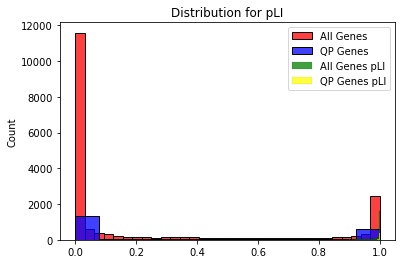

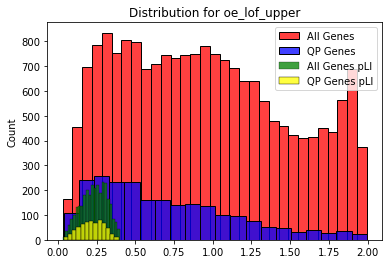

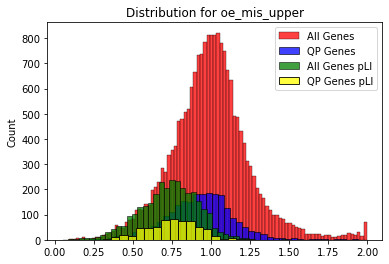

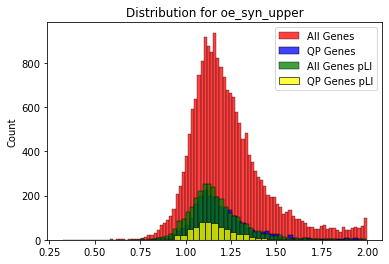

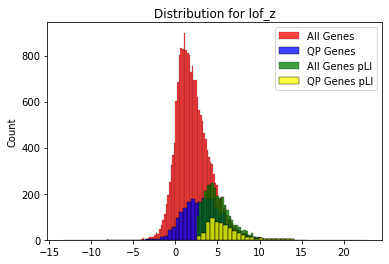

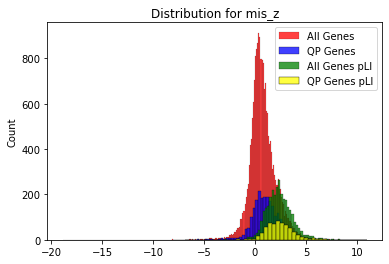

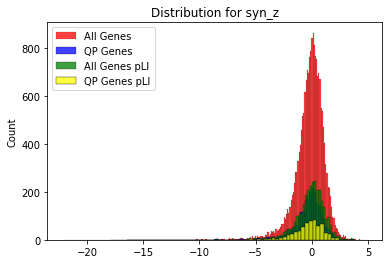

In [28]:
# List of columns to plot
columns = ['pLI', 'oe_lof_upper', 'oe_mis_upper', 'oe_syn_upper', 'lof_z', 'mis_z', 'syn_z']

# Iterate over each column
for column in columns:
    if column in qp_gnomad.columns and column in gnomad.columns:
        # Convert the pandas Series to numpy arrays
        data_qp_gnomad = np.array(qp_gnomad[column])
        data_gnomad = np.array(gnomad[column])
        data_gnomad_pli = np.array(gnomad[gnomad['pLI'] >= .9][column])
        data_qp_gnomad_pli = np.array(qp_gnomad[qp_gnomad['pLI'] >= .9][column])
        
        # Plot distributions
        sns.histplot(data_gnomad, color='red', label='All Genes')
        sns.histplot(data_qp_gnomad, color='blue', label='QP Genes')
        sns.histplot(data_gnomad_pli, color='green', label='All Genes pLI')
        sns.histplot(data_qp_gnomad_pli, color='yellow', label='QP Genes pLI')
        
        # Set title and show legend
        plt.title(f'Distribution for {column}')
        plt.legend()

        # Show the plot
        plt.show()

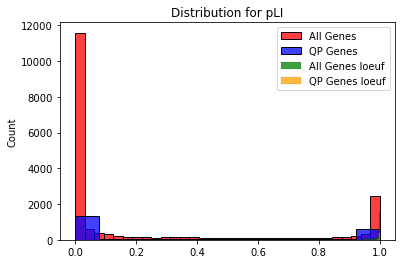

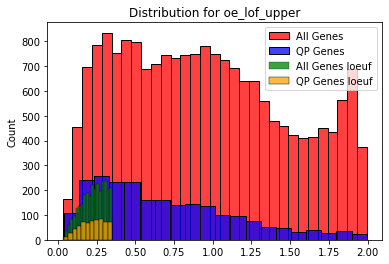

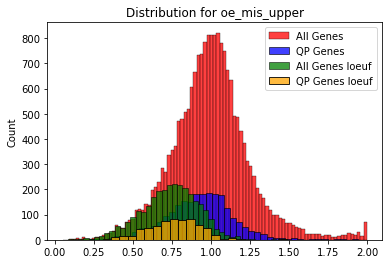

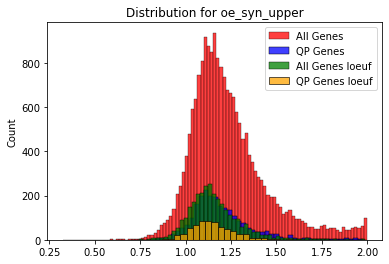

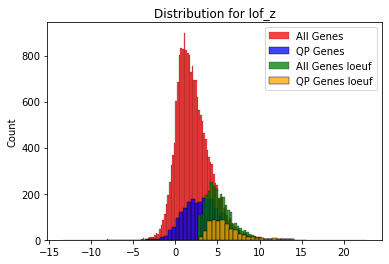

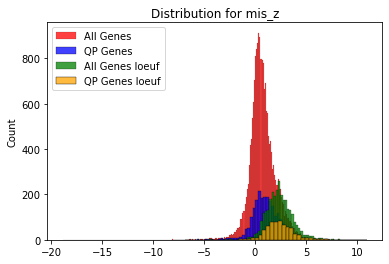

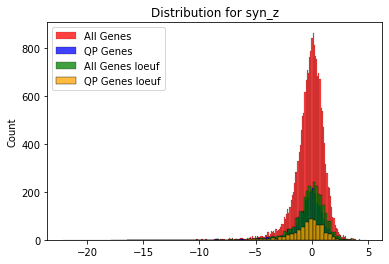

In [29]:
# List of columns to plot
columns = ['pLI', 'oe_lof_upper', 'oe_mis_upper', 'oe_syn_upper', 'lof_z', 'mis_z', 'syn_z']

# Iterate over each column
for column in columns:
    if column in qp_gnomad.columns and column in gnomad.columns:
        data_qp_gnomad = np.array(qp_gnomad[column])
        data_gnomad = np.array(gnomad[column])
        data_gnomad_loeuf = np.array(gnomad[gnomad['oe_lof_upper'] < .35][column])
        data_qp_gnomad_loeuf = np.array(qp_gnomad[qp_gnomad['oe_lof_upper'] < .35][column])
        

        # Plot distributions
        sns.histplot(data_gnomad, color='red', label='All Genes')
        sns.histplot(data_qp_gnomad, color='blue', label='QP Genes')
        sns.histplot(data_gnomad_loeuf, color='green', label='All Genes loeuf')
        sns.histplot(data_qp_gnomad_loeuf, color='orange', label='QP Genes loeuf')
        
        # Set title and show legend
        plt.title(f'Distribution for {column}')
        plt.legend()

        # Show the plot
        plt.show()

In [30]:
# Enrichment test
N = 19969 # number of genes found in the human genome
K = len(qp)
n = len(nq)
k = len(q)

# Perform the hypergeometric test
p_value = hypergeom.sf(k - 1, N, K, n)

print("Constraint Enrichment based on pLI:")

print("P-value:", p_value)

# Calculate odds ratio
odds_ratio1 = (k / n) / (K / N)

print("Odds Ratio:", odds_ratio1)

# Calculate effect size (Cohen's h)
p1 = k / n
p2 = K / N
h = 2 * np.arcsin(np.sqrt(p1)) - 2 * np.arcsin(np.sqrt(p2))

print("Effect Size (Cohen's h):", h)

Constraint Enrichment based on pLI:
P-value: 2.6510572812177287e-45
Odds Ratio: 1.660260021611641
Effect Size (Cohen's h): 0.22304105541726038


In [31]:
# Enrichment test
N = 19969 # number of genes found in the human genome
K = len(qp)
n = len(nql)
k = len(ql)

# Perform the hypergeometric test
p_value = hypergeom.sf(k - 1, N, K, n)

print("Constraint Enrichment based on LOEUF:")

print("P-value:", p_value)

# Calculate odds ratio
odds_ratio2 = (k / n) / (K / N)

print("Odds Ratio:", odds_ratio2)

# Calculate effect size (Cohen's h)
p1 = k / n
p2 = K / N
h = 2 * np.arcsin(np.sqrt(p1)) - 2 * np.arcsin(np.sqrt(p2))

print("Effect Size (Cohen's h):", h)

Constraint Enrichment based on LOEUF:
P-value: 1.2326406868212077e-57
Odds Ratio: 1.7684210768258968
Effect Size (Cohen's h): 0.2559594152236696


In [32]:
# Assuming odds_ratio1 and odds_ratio2 are the values you calculated above
odds_ratios = [odds_ratio1, odds_ratio2]

# Define categories
categories = [">=0.9 pLI", "<0.35 LOEUF"]

# Define colors
colors = ["#1f77b4", "#ff7f0e"]

# Define gene counts (replace with your actual counts)
gene_counts = [len(q), len(ql)]

# Output to notebook
output_notebook()

# Create a new plot without a title and with a larger width
p = figure(y_range=FactorRange(factors=categories), x_range=(0, 2), plot_width=1000, y_axis_label=' ', x_axis_label='Enrichment')

# Add a bar renderer for each odds ratio
p.hbar(y=categories, right=odds_ratios, height=0.5, line_color="Black", line_width=1, fill_color=colors)

# Add gene counts next to each bar
for i, gene_count in enumerate(gene_counts):
    p.text(x=odds_ratios[i]+0.1, y=i+0.46, text=[str(gene_count)], text_align="center")

# Increase x and y axis label text size
p.xaxis.axis_label_text_font_size = '17pt'

# Increase x and y major label text size
p.xaxis.major_label_text_font_size = '15pt'
p.yaxis.major_label_text_font_size = '15pt'

# Add a vertical line at x=1
vline = Span(location=1, dimension='height', line_color='black', line_width=2, line_dash="dashed")
p.renderers.extend([vline])

# Show the results
show(p)


Loading BokehJS ...

In [34]:
grouped3 = grouped2.groupby(['oe_lof_upper_bin', 'most_severe_consequence'])['enrichment'].sum().reset_index()
grouped3 = grouped3.groupby('oe_lof_upper_bin')['enrichment'].sum().reset_index()

# Calculate Spearman Rank correlation and corresponding p-value
rho, p = spearmanr(grouped3['oe_lof_upper_bin'], grouped3['enrichment'])

print("rho: ",rho)  
print("pvalue: ",p)  


rho:  -0.9878787878787878
pvalue:  9.307459988955517e-08


In [ ]:
import session_info
session_info.show()